Welcome to part three of the "from scratch" series where we implement machine learning models from the ground up. The model we will implement today, called the naive Bayes classifier, is an interesting model that nicely builds on top of the Bayesian mindset we developed in the [previous post] on Markov Chain Monte Carlo. Much like the logistic regression model, naive Bayes can be used to solve classification tasks, as opposed to regression in which case the goal is to predict a continuous variable. The main difference between logistic regression and naive Bayes is that naive Bayes is built on a probabilistic model instead of an optimization model such as graident descent. Hence, implementing naive Bayes is somewhat easier from a programming point of view. Enough of the prologue, let's cut to the chase.

# Bayesian Thinking

To understand naive Bayes, we need not look further than Bayes's theorem, which is probably the single most referenced theorem on this blog so far. I won't explain this much since we have already seen it so many times, but presented below is the familar formula for reference and readability's sake. 

$$P(y \vert X) = \frac{P(X \vert y) P(y)}{P(X)} \tag{1}$$

Very standard, perhaps with the exception of some minor notation. Here, $X \in \mathbb{R}^n$ refers to a single instance, represented as a vector with $n$ entries; $y$, the corresponding label or class for that instance. Note that $X$ is not a feature matrix, but a single instance. More concretely, 

$$X = \begin{pmatrix} x_1 & x_2 & \cdots & x_n \end{pmatrix}^T$$

Of course, $y$ is just a scalar value. This characterization is very apt in the context of machine learning. The underlying idea is that, given some data with $n$ feature columns, we can derive a probability distribution for the label for that intance. 

The naive assumption that the naive Bayes classifier makes---now you can guess where that name comes from---is that each of the $n$ variables in the instance vector are independent of one another. In other words, knowing a value for one of the features does not provide us with any information about the values for the other $n - 1$ feature columns. Combining this assumption of independence with Bayes' theorem, we can now restate (1) as follows:

$$P(y \vert x_1 \dots x_n) = \frac{P(x_1 \vert y) \cdots P(x_n \vert y) P(y)}{P(x_1) \cdots P(x_n)} \tag{2}$$

Pretty straight forward. We know that the demominator, which often goes by the name "evidence" in Bayesian inference, is merely a normalizing factor to ensure that the posterior distribution integrates to 1. So we can discard this piece of information and distill (2) down even farther:

$$P(y \vert x_1 \dots x_n) \propto P(y) \prod_{i=1}^n P(x_i \vert y) \tag{3}$$

Equation (3) tells us that it is possible to calculate the probability of instance $X$ belonging to class $y$ systematically. Why is this important? The simple answer is that we can use (3) to train the naive Bayes classifier. Say we know that for a particular instance $X_i$, the label is $y_i$. Then, we have to find the distribution for each feature such that we can maximize $P(y_i \vert X_i)$. Does this ring any bells? Yes---it is maximum a posteriori estimation! In other words, our goal would be to maximize the posterior distribution for each training instance so that we can eventually build a model that would output the most likely label that the testing instance belongs to. In other words, our training scheme can be summarized as:

$$\hat{y} = \mathop{\rm arg\,max}\limits_{y} P(y) \prod_{i=1}^n P(x_i \vert y) \tag{4}$$

But this is all to abstract. Let's get into the details by implementing the naive Bayes classifer from scratch. Before we proceed, however, I must tell you that there are many variations of the naive Bayes classifer. The variant that we will implement today is called the Gaussian naive Bayes classifer, because we assume that the distribution of the feature variables, denoted as $x_i$, is normal. For a corresponding explanation of this model on `sklearn`, refer to [this documentation]. Let's jump right into it.

# Building Naive Bayes

As per convention, we start by importing necessary modules for this tutorial. For reproducability, we specify a `seed`. The `%` magic commands are for the configuration of this Jupyter Notebook.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm
plt.style.use('seaborn')
np.random.seed(123)

Let's begin by building some toy data. To make things simple, we will recycle the toy data set we used in the previous post on [logistic regression] and [k-nearest neighbors]. The advantage of using this data set is that we can easily visualize our data since all instances live in $\mathbb{R}^2$. In other words, we only have two axes: $x_1$ and $x_2$. For convenience, we preprocess our toy data set and labels into `numpy` arrays.

In [2]:
dataset = np.array([[2.7810836,2.550537003],
           [1.465489372,2.362125076],
           [3.396561688,4.400293529],
           [1.38807019,1.850220317],
           [3.06407232,3.005305973],
           [7.627531214,2.759262235],
           [5.332441248,2.088626775],
           [6.922596716,1.77106367],
           [8.675418651,-0.242068655],
           [7.673756466,3.508563011]])
label = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

## Identifying Gaussian Parameters

The first step is to separate the data set by class values, since our goal is to find the distributions for each class that best describe the given data through MAP. To achieve this objective, we can create a function that returns a dictionary, where the key represents the class and the values contain the entries of the data set. One way to implement this process is represented below in the `separate_by_class` function.

In [3]:
def separate_by_class(X, y):
    class_dict ={}
    for i, label in enumerate(y):
        if label in class_dict:
            class_dict[label].append(i)
        else:
            class_dict[label] = [i]
    for k, v in class_dict.items():
        class_dict[k] = X[v]
    return class_dict

Let's see if the function works properly by passing `dataset` as into its argument. 

In [4]:
class_dict = separate_by_class(dataset, label)
class_dict

{0: array([[2.7810836 , 2.550537  ],
        [1.46548937, 2.36212508],
        [3.39656169, 4.40029353],
        [1.38807019, 1.85022032],
        [3.06407232, 3.00530597]]), 1: array([[ 7.62753121,  2.75926224],
        [ 5.33244125,  2.08862677],
        [ 6.92259672,  1.77106367],
        [ 8.67541865, -0.24206865],
        [ 7.67375647,  3.50856301]])}

Great! As expected, `class_dict` is a dictionary whose keys represent the class and values contain entries corresponding to that class. Now that we have successfully separated out the data by class, its' time to write a function that will find the mean and standard deviation of each class data. This process is legitimate only because we assumed the data to be normally distributed---hence the name "Gaussian naive Bayes." Let's quickly see this in code. 

In [7]:
def summarizer(data):
    summary = [[np.mean(column), np.std(column)] for column in zip(*data)]
    return summary

The `summarizer` function receives a data set as input and returns a nested list that contains the mean and standard deviation of each column of the data set. For example, if we pass the toy data set `dataset` into `summarizer`, the returned list will contain two lists: the first list element corresponding to the mean and standard deviation of $x_1$, and the second list element, $x_2$. 

In [8]:
summarizer(dataset)

[[4.8327021465, 2.6051838419314794], [2.4053928934, 1.1629554833322375]]

We can combine both `summarizer` and `separate_by_class` functions to create a new wrapper function `summarize_by_class` that returns the mean and standard deviation of each column for each class. This is a crucial step that will allow us to perform a MAP approximation for the distribution of variables for each class. 

In [9]:
def summarize_by_class(class_dict):
    summary_dict = {}
    for k, v in class_dict.items():
        summary_dict[k] = summarizer(v)
    return summary_dict

Testing out the function on `class_dict` created earlier yields the desired result. Notice that the returned dictionary contains information for each class, where the key corresponds to the label and the value contains the parameters calculated from `summarizer`.

In [10]:
summarize_by_class(class_dict)

{0: [[2.4190554339999997, 0.833648422388659],
  [2.8336963796, 0.8664248811868022]],
 1: [[7.246348858999999, 1.1079779342778044],
  [1.9770894072, 1.2599012203753612]]}

A good way to understand this data is through visualization. Let's try to visualize what the distribution of $x_1$ and $x_2$ looks like for data labeled class `0`. We can use the `seaborn` library to create a joint plot of the two random variables. 

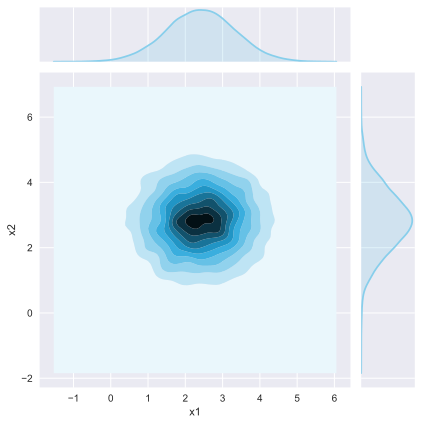

In [9]:
x1, x2 = np.random.RandomState(8).multivariate_normal([2.4190554339999997, 2.8336963796], [(0.833648422388659, 0), (0, 0.8664248811868022)], 10000).T
df = pd.DataFrame({"x1":x1,"x2":x2})
sns.jointplot(data=df, x='x1', y='x2', kind='kde', color='skyblue')
plt.show()

We see that both variables are normally distributed. Therefore, we can imagine data points for class `0` to be distributed across a three-dimensional Gaussian distribution whose center lies at the point where the the plot has the darkest color, *i.e.* $(\mu_{x_1}, \mu_{x_2})$. I find this way of understanding data to be highly intuitive in this context.

## Bayesian Modeling

Now, it's time to bake Bayesian philosophy into code. Recall that to perform Bayesian analysis, we first need to specify a prior. Although we could use an uninformed prior, in this case, we have data to work with. The way that makes the most sense would be to count the number of data points corresponding to each class to create a categorical distribution and use that as our prior, as shown below.

In [18]:
def prior(class_dict, y):
    prior_dict = {}
    total_num = len(y)
    for k, v in class_dict.items():
        prior_dict[k] = len(v)/total_num
    return prior_dict

If we use the `class_dict` created from `dataset`, we should get a very simple prior whereby $P(X_{class} = 0) = P(X_{class} = 1) = 0.5$ since there is an equal number of data points belonging to the two classes in the toy data set. Indeed, this seems to be true.

In [12]:
prior(class_dict, label)

{0: 0.5, 1: 0.5}

Next, it's time to model the likelihood function. I won't get into the specifics of this function, but all it does is that it calculates the likelihood by using the parameters returned by the `summarize_by_class` function to indicate the likelihood that a particular `test_instance` belongs to a certain class. As per convention of this tutorial, the returned dictionary has keys corresponding to each class and values indicating the likelihood that the `test_instance` belongs to that class. 

In [13]:
def likelihood(class_dict, test_instance):
    likelihood_dict = {}
    feature_summary = summarize_by_class(class_dict)
    for k in feature_summary.keys():
        value = feature_summary[k]
        for i, feature in enumerate(value):
            if k in likelihood_dict:
                likelihood_dict[k] *= norm(feature[0], feature[1]).pdf(test_instance[i])
            else:
                likelihood_dict[k] = norm(feature[0], feature[1]).pdf(test_instance[i])
    return likelihood_dict

We can see the `likelhood` function in action by passing a dummy test instance.

In [14]:
likelihood(class_dict, [8.675418651,-0.242068655])

{0: 2.379134694332673e-16, 1: 0.010520187742829746}

We are almost done! All that we have to do is to create a funcition that returns the predicted label of a testing instance given some labeled training data. Implemenitng this process is straightforward since we have all the Bayesian ingredients we need, namely the prior and the likelihood. The last step is to connect the dots with Bayes' theorem by calculating the product of the prior and likelihood for each class, then return the class label with the largest posterior, as illustrated below.

In [15]:
def make_prediction(training_set, label, testing_instance):
    class_dict = separate_by_class(training_set, label)
    class_probability = prior(class_dict, label)
    likelihood_dict = likelihood(class_dict, testing_instance)
    prediction = {k: class_probability[k] * likelihood_dict[k] for k in class_probability}
    return max(prediction.keys(), key=lambda k: prediction[k])

Let's see if the `make_prediction` works as expected by seeing if passing as argument `dataset[9]`, for which we know that its label is 1, actually returns 1. 

In [16]:
make_prediction(dataset, label, dataset[9])

1

The `make_prediction`function is only able to process a single testing instance. Let's complete our model construction by writing the `naive_bayes` function that takes labeled data and a testing set as its argument to return a `numpy` array containing the predicted class labels for each instance in the testing set. 

In [19]:
def naive_bayes(training_set, label, testing_set):
    prediction = []
    for instance in testing_set:
        prediction.append(make_prediction(training_set, label, instance))
    return np.array(prediction)

Done!

# Testing the Model

Let's import some data from the `sklearn` library. The wine set data is a classic multi-class classfication data set. The data set contains three target classes, labeled as integers from 0 to 2, and thirteen feature columns, listed below:

* Alcohol 
* Malic acid 
* Ash 
* Alcalinity of ash 
* Magnesium 
* Total phenols 
* Flavanoids 
* Nonflavanoid phenols 
* Proanthocyanins 
* Color intensity 
* Hue 
* OD280/OD315 of diluted wines 
* Proline 

As I am not a wine afficionado, I have no idea what some of these columns represent, but that is irrelevant to the purpose of this tutorial. Let's jump right in by loading the data.

In [21]:
from sklearn import datasets

wine_X, wine_y = datasets.load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = my_train_test_split(wine_X, wine_y, 0.2, 123)

It always a good idea to get a sense of what the data looks like by verifying its dimension. 

In [22]:
X_train.shape

(143, 13)

Note that we used the `my_train_test_split` function we wrote in previous posts to shuffle and slice the data into training and validation sets. For convenience, the code for this function is presented below. 

In [20]:
def my_train_test_split(X, y, test_size, random_state=None):
    data_num = len(y)
    test_num = int(test_size * data_num)
    if random_state != None: np.random.seed(random_state)
    index = np.random.permutation(data_num)
    X_train = X[index[:-test_num]]
    X_test = X[index[-test_num:]]
    y_train = y[index[:-test_num]]
    y_test = y[index[-test_num:]]
    return X_train, X_test, y_train, y_test

Now it's finally time to check our model by making predictions. This can simply be done by passing the training and testing data set into the `naive_bayes` function that represented our Gaussian naive Bayes model. 

In [23]:
y_pred = naive_bayes(X_train, y_train, X_test)
y_pred

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 1, 0, 0, 0, 1, 2, 1, 2, 2, 1, 0, 1,
       0, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1])

Let's check if the predicted class labels match the answer key, *i.e.* the `y_test` array. 

In [24]:
y_test

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 1, 0, 0, 0, 1, 2, 1, 2, 2, 1, 0, 1,
       0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])

Eyeballing the results, it seems like we did reasonably well! In fact, the line below tells us that our model mislabeled only one test instance!

In [25]:
y_pred == y_test

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True])

We can quantify the performance our model through the metric of accuracy. The `accuracy_score` function does this for us. Note that instead of using the for-loop approach used in previous posts, this function is more vectorized, making computation less expensive. The shorter code is also an added benefit.

In [28]:
def accuracy_score(y_true, y_pred):
    return sum(y_true == y_pred)/len(y_true)

accuracy_score(y_test, y_pred)

0.9714285714285714

The accuracy of our from-scratch model is 97 percent, which is not bad for a start. Let's see if the `GaussianNB` model in `sklearn` outperforms our hand-coded model. 

In [29]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
y_pred_sklearn = model.predict(X_test)
accuracy_score(y_test, y_pred_sklearn)

0.9714285714285714

The accuray score yielded by `GaussianNB` is exactly identical to that achieved by our model! Looks like the `GaussianNB` model in scikit-learn does exactly what our model does, at least juding from the metric of accuracy. This is surprising, but since we basically followed the Bayesian line of reasoning to buid our model, which is what naive Bayes really is all about, perhaps this is not as astonishing as it seems. 

# Conclusion

In this post, we built the Gaussian naive Bayes model from scratch. In the process, we reviewed key concepts such as Bayesian inference and maximum a posteriori estimation, both of which are key statistical concepts used in many subdomains of machine learning. Hopefully through this tutorial, you gained a better understanding of how Gaussian mathematics and Bayesian thinking can be used in the context of classification. The true power of naive Bayes is not limited to the task of classificaiton, however. In fact, it is used in many fields, most notably natural language processing. Perhaps we might look into the possible applications of naive Bayes in the context of NLP in a future post. But for now, this level of modeling will do.

Thanks for reading. See you in the next post!

[post]: https://jaketae.github.io/study/map-mle/
[this documentation]: https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes
[logistic regression]: https://jaketae.github.io/study/logistic-regression/
[k-nearest neighbors]: https://jaketae.github.io/study/KNN/
[previous post]: https://jaketae.github.io/study/MCMC/